## [Kaggle Competition Link](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation)

In [1]:
# ! pip install segmentation-models
# ! pip uninstall segmentation-models -y
# ! pip install git+https://github.com/qubvel/segmentation_models

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
import gc
from tqdm import tqdm
from datetime import datetime
from typing import Optional
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras.models import load_model, save_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.layers import Input


import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
# from config import *  This works but commenting out as I need to run this entire NB in Kaggle

2022-05-10 19:55:04.983409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-10 19:55:04.983440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Config

In [3]:
import os

BATCH_SIZE = 16
EPOCHS = 10
n_splits = 5
fold_selected = 2  # 1,...,5

#### ONLY CHANGE DIRECTORIES HERE AND NO NEED TO CHANGE IT ANYWHERE ELSE IN THIS NOTEBOOK #####
# Kaggle Root Dir
# TRAIN_ROOT_DIR = "../input/uw-madison-gi-tract-image-segmentation/"
# TEST_ROOT_DIR = "../input/uw-madison-gi-tract-image-segmentation/test"

TRAIN_ROOT_DIR = "../../input/uw-madison-gi-tract-image-segmentation/"
TEST_ROOT_DIR = "../../input/uw-madison-gi-tract-image-segmentation/test/"

# Basic EDA

In [4]:
train_df_original = pd.read_csv(TRAIN_ROOT_DIR + 'train.csv')

print(train_df_original.shape)
train_df_original.head()

(115488, 3)


id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

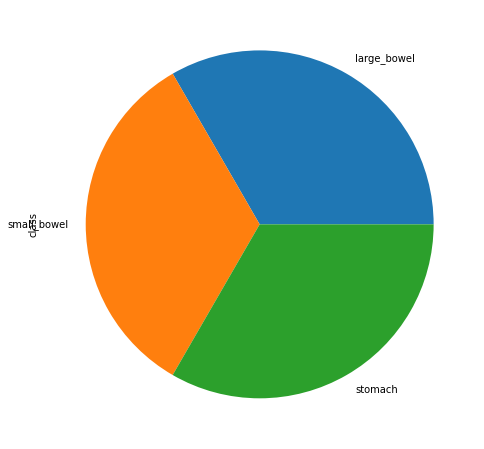

In [5]:
plt.figure(figsize=(28, 8))
train_df_original['class'].value_counts(normalize=True).plot.pie();

### Test image set in Local Machine

In [6]:
test_df = pd.read_csv(TRAIN_ROOT_DIR + 'sample_submission.csv')
test_df.head()

Empty DataFrame
Columns: [id, class, predicted]
Index: []

In [7]:
test_df = pd.read_csv(TRAIN_ROOT_DIR + 'sample_submission.csv')

if len(test_df)==0:
    DEBUG=True
    test_df = train_df_original.iloc[:300,:]
    test_df["segmentation"]=''
    test_df=test_df.rename(columns={"segmentation":"prediction"})
else:
    DEBUG=False

submission=test_df.copy()
test_df.head()

id        class prediction
0  case123_day20_slice_0001  large_bowel           
1  case123_day20_slice_0001  small_bowel           
2  case123_day20_slice_0001      stomach           
3  case123_day20_slice_0002  large_bowel           
4  case123_day20_slice_0002  small_bowel

## Function to create a detailed df from train_df

- Create columns with 'case', 'day', 'slice'

In [8]:
def df_preparation(df, subset="train"):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    
    if (subset=="train") or (DEBUG):
        DIR=TRAIN_ROOT_DIR+'train'
    else:
        DIR=TEST_ROOT_DIR
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df

In [9]:
train_df = df_preparation(train_df_original, subset="train")
train_df.head(20)

id        class segmentation  case  day slice  \
0   case123_day20_slice_0001  large_bowel                123   20  0001   
1   case123_day20_slice_0001  small_bowel                123   20  0001   
2   case123_day20_slice_0001      stomach                123   20  0001   
3   case123_day20_slice_0002  large_bowel                123   20  0002   
4   case123_day20_slice_0002  small_bowel                123   20  0002   
5   case123_day20_slice_0002      stomach                123   20  0002   
6   case123_day20_slice_0003  large_bowel                123   20  0003   
7   case123_day20_slice_0003  small_bowel                123   20  0003   
8   case123_day20_slice_0003      stomach                123   20  0003   
9   case123_day20_slice_0004  large_bowel                123   20  0004   
10  case123_day20_slice_0004  small_bowel                123   20  0004   
11  case123_day20_slice_0004      stomach                123   20  0004   
12  case123_day20_slice_0005  large_bowel                123   20  0005   
13  case123_day20_slice_0005  small_bowel                123   20  0005   
14  case123_day20_slice_0005      stomach                123   20  0005   
15  case123_day20_slice_0006  large_bowel                123   20  0006   
16  case123_day20_slice_0006  small_bowel                123   20  0006   
17  case123_day20_slice_0006      stomach                123   20  0006   
18  case123_day20_slice_0007  large_bowel                123   20  0007   
19  case123_day20_slice_0007  small_bowel                123   20  0007   

                                                 path  width  height  
0   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
1   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
2   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
3   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
4   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
5   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
6   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
7   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
8   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
9   ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
10  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
11  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
12  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
13  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
14  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
15  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
16  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
17  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
18  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
19  ../../input/uw-madison-gi-tract-image-segmenta...    266     266

In [10]:
# Checking a single full path name
train_df['path'][0]

'../../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

In [11]:
test_df=df_preparation(test_df, subset="test")
test_df.head()

id        class prediction  case  day slice  \
0  case123_day20_slice_0001  large_bowel              123   20  0001   
1  case123_day20_slice_0001  small_bowel              123   20  0001   
2  case123_day20_slice_0001      stomach              123   20  0001   
3  case123_day20_slice_0002  large_bowel              123   20  0002   
4  case123_day20_slice_0002  small_bowel              123   20  0002   

                                                path  width  height  
0  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
1  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
2  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
3  ../../input/uw-madison-gi-tract-image-segmenta...    266     266  
4  ../../input/uw-madison-gi-tract-image-segmenta...    266     266

In [12]:
test_df['path'][0]

'../../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

## Rearrange train_df

**string[::2]** => reads “default start index, default stop index, step size is two 
  — i.e. take every second element”. So it means, 'nothing for the first argument, nothing for the second, and jump by 2.

In [13]:
df_out = pd.DataFrame({'id': train_df['id'][::3]})
df_out.head(10)

id
0   case123_day20_slice_0001
3   case123_day20_slice_0002
6   case123_day20_slice_0003
9   case123_day20_slice_0004
12  case123_day20_slice_0005
15  case123_day20_slice_0006
18  case123_day20_slice_0007
21  case123_day20_slice_0008
24  case123_day20_slice_0009
27  case123_day20_slice_0010

--------------

## Rearrange Train Data Frame

## In train.csv, for each id, we have 3 associated row representing the segmentation for the 3 classes. 'large_bowel', 'small_bowel', 'stomach'

Now I want to create extra 3 columns with the same segmentation names, and assign corresponding values. 

Hence in below, using the slice notation I am extracting the consecutive 3 rows values

![Imgur](https://imgur.com/1ss5FZ6.png)

In above image, we can see, in the original df, each row is repeated 3 times for the 3 classes of segmentation.

In below method

- First, I am creating 3 extra columns and filling their values by taking the 3 consecutive row's value from the original df
- Then for the rest of the column values, I need to take values from the original df skipping 3 rows each time, as in the original df, each row is repeated 3 times for the 3 classes of segmentation.


In [14]:
def df_rearrange_for_3_segmentation_classes(df, subset="train"):
    df_restructured = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_restructured['large_bowel'] = df['segmentation'][::3].values
        df_restructured['small_bowel'] = df['segmentation'][1::3].values
        df_restructured['stomach'] = df['segmentation'][2::3].values

    df_restructured['path'] = df['path'][::3].values
    df_restructured['case'] = df['case'][::3].values
    df_restructured['day'] = df['day'][::3].values
    df_restructured['slice'] = df['slice'][::3].values
    df_restructured['width'] = df['width'][::3].values
    df_restructured['height'] = df['height'][::3].values

    df_restructured=df_restructured.reset_index(drop=True)
    df_restructured=df_restructured.fillna('')
    if subset=="train":
        df_restructured['count'] = np.sum(df_restructured.iloc[:,1:4]!='',axis=1).values
    
    return df_restructured

 df[:, 1:4] - With a comma - All Rows but from column index 1 to colum index (4 - 1) i.e. upto column index 3

In [15]:
train_df_rearranged=df_rearrange_for_3_segmentation_classes(train_df, subset="train")
train_df_rearranged.head(2)
# train_df.shape

id large_bowel small_bowel stomach  \
0  case123_day20_slice_0001                                   
1  case123_day20_slice_0002                                   

                                                path  case  day slice  width  \
0  ../../input/uw-madison-gi-tract-image-segmenta...   123   20  0001    266   
1  ../../input/uw-madison-gi-tract-image-segmenta...   123   20  0002    266   

   height  count  
0     266      0  
1     266      0

In [16]:
test_df_rearranged =df_rearrange_for_3_segmentation_classes(test_df, subset="test")
test_df_rearranged.head()

id  \
0  case123_day20_slice_0001   
1  case123_day20_slice_0002   
2  case123_day20_slice_0003   
3  case123_day20_slice_0004   
4  case123_day20_slice_0005   

                                                path  case  day slice  width  \
0  ../../input/uw-madison-gi-tract-image-segmenta...   123   20  0001    266   
1  ../../input/uw-madison-gi-tract-image-segmenta...   123   20  0002    266   
2  ../../input/uw-madison-gi-tract-image-segmenta...   123   20  0003    266   
3  ../../input/uw-madison-gi-tract-image-segmenta...   123   20  0004    266   
4  ../../input/uw-madison-gi-tract-image-segmenta...   123   20  0005    266   

   height  
0     266  
1     266  
2     266  
3     266  
4     266

## Incorrect masks

https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/319963

It seems the masks for case7_day0 and case81_day30 are incorrect, as they don't line up with the anatomy. You might want to leave them out of your training.

![Imgur](https://imgur.com/WvuT7Cc.png)


https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/321979

* CASE 7 –– DAY 0  and  
* CASE 81 –– DAY 30 and
* CASE 138 –– DAY 0

In [17]:
# Remove misslabeled training data
train_df_rearranged = train_df_rearranged[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df_rearranged = train_df_rearranged[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)
train_df_rearranged = train_df_rearranged[(train_df['case']!=138)|(train_df['day']!=00)].reset_index(drop=True)

 you can explicitly invoke the Garbage Collector to release unreferenced memory with gc.collect(). Example:

In [18]:
gc.collect()

2370

# Util Functions

In [19]:
# https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode/script
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [20]:
# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [21]:
# Images reshaped to (128,128)
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]  # selects the row number of indexes[i]
            h=self.df['height'].iloc[indexes[i]]
            img = self.load_grayscaled_img(img_path)  # shape: (128,128,1)
            X[i,] =img   # broadcast to shape: (128,128,3)
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (128, 128))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
    def load_grayscaled_img(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        img_size = (128, 128)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img
    
    '''cv2.IMREAD_ANYDEPTH => If set, return 16-bit/32-bit image when the input has the corresponding depth, otherwise convert it to 8-bit. '''

# EDA

In [22]:
def plot_bar(df):
    plt.figure(figsize=(12,4))
    bar = plt.bar([1,2,3],100*np.mean(df.iloc[:,1:4]!='',axis=0))
    plt.title('Percent Training Images with Mask', fontsize=16)
    plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
    plt.xticks([1,2,3])
    labels=["large bowel","small bowel","stomach"]

    for rect, lbl in zip(bar, labels):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
                ha='center', va='bottom',fontsize=16)
        plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
                ha='center', va='bottom',fontsize=13)

    plt.ylim((0,50))
    plt.show()

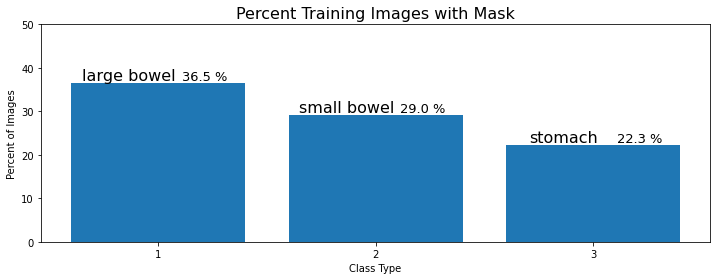

In [23]:
plot_bar(train_df_rearranged)

The `matplotlib.colors.ListedColormap` class belongs to the `matplotlib.colors` module. This module is used for converting color or numbers arguments to RGBA or RGB and for mapping numbers to colors or color specification conversion in a 1-D array of colors also known as colormap.

The matplotlib.colors.ListedColormap class is used to create colarmap objects from a list of colors. This can be useful for directly indexing into colormap and it can also be used to create special colormaps for normal mapping.

### `mask1=mask[0,:,:,0]`

First in the case of 2-D Matrix 

- x[:, 0] => Means taking all rows (:) but keeping the first column (0)

- x[:, 1] => Means taking all rows (:) but keeping the second column (1)

- x[:, 0::2] =>  All Rows BUT Every other column starting from the first column. ‘:’ means selecting all the indexes.  Here ‘:’ is selecting all the rows.  As the column input we put 0::2.

https://regenerativetoday.com/indexing-and-slicing-of-1d-2d-and-3d-arrays-using-numpy/


---------------

### `mask1` represents all the area that is NOT `'large_bowel'`
### `mask2` represents all the area that is NOT `'small_bowel'`
### `mask3` represents all the area that is NOT `'stomach_bowel'`

===========================================================================

### `numpy.MaskedArray.masked_where()` function is used to mask an array where a condition is met.

Return a as an array masked where condition is True. Any masked values of a or condition are also masked in the output.

```
ma.masked_where(condition, array, copy=True)
```

===========================================================================

### `mask1` represents all the area that is `'large_bowel'` - 

Hence, `np.ma.masked_where(mask1== False,  mask1)` will put a "-" to all regions of the "mask1" array where `mask1== False`

Means, All Non-Mask area will be taken out by putting "-"


### `mask2` represents all the area that is `'small_bowel'`
### `mask3` represents all the area that is `'stomach_bowel'`

In [67]:
# https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-keras-train-with-eda?scriptVersionId=94128751&cellId=12 - GM
def plot_mask_with_color_patches(df, colors, labels):
    Masks = list(df[df['large_bowel']!=''].sample(BATCH_SIZE).index)
    Masks += list(df[df['small_bowel']!=''].sample(BATCH_SIZE*2).index)
    Masks += list(df[df['stomach']!=''].sample(BATCH_SIZE*3).index)

    batches_from_datagen = DataGenerator(df[df.index.isin(Masks)],shuffle=True)
    
    num_rows = 6

    fig = plt.figure(figsize=(10, 25))
    gs = gridspec.GridSpec(nrows=num_rows, ncols=2)
    patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

    cmap1 = mpl.colors.ListedColormap(colors[0])
    cmap2 = mpl.colors.ListedColormap(colors[1])
    cmap3= mpl.colors.ListedColormap(colors[2])

    for i in range(num_rows):
        images, mask = batches_from_datagen[i]
        # print('images.shape ', images.shape) # (16, 128, 128, 3)
        # print('mask.shape ', mask.shape) # (16, 128, 128, 3)
        
        sample_img=images[0,:,:,0]      # After this the shapes will be (128, 128)
        mask1=mask[0,:,:,0]             # After this the shapes will be (128, 128)
        mask2=mask[0,:,:,1]             # After this the shapes will be (128, 128)
        mask3=mask[0,:,:,2]             # After this the shapes will be (128, 128)
        
        ax0 = fig.add_subplot(gs[i, 0])
        im = ax0.imshow(sample_img, cmap='bone')

        ax1 = fig.add_subplot(gs[i, 1])
        if i==0:
            ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
            ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
            plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

        # print('mask1 ', mask1.shape) # (128, 128)
        # print('mask2 ', mask2.shape) # (128, 128)
        # print('mask3 ', mask3.shape) # (128, 128)
        # print('np.ma.masked_where(mask1== False,  mask1) ', np.ma.masked_where(mask1== True,  mask1))
        l0 = ax1.imshow(sample_img, cmap='bone')
        l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
        l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
        l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
        # l1 = ax1.imshow(np.ma.masked_where(mask1== 0,  mask1),cmap=cmap1, alpha=1)
        # l2 = ax1.imshow(np.ma.masked_where(mask2== 0,  mask2),cmap=cmap2, alpha=1)
        # l3 = ax1.imshow(np.ma.masked_where(mask3== 0,  mask3),cmap=cmap3, alpha=1)
        _ = [ax.set_axis_off() for ax in [ax0,ax1]]

        colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

### 0 is taken as black and 1 as white. 

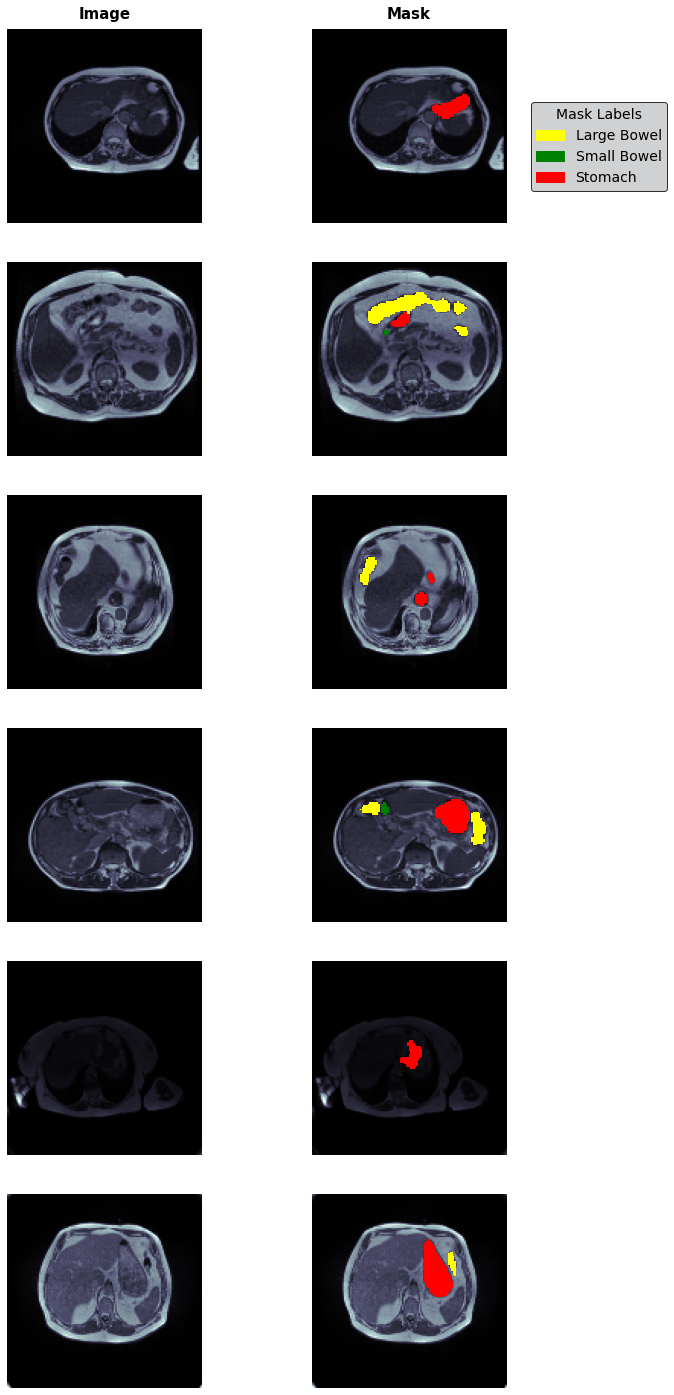

In [68]:
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]

plot_mask_with_color_patches(train_df_rearranged, colors, labels)

# CV

In [27]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df_rearranged, y=train_df_rearranged['count'], groups=train_df_rearranged['case']), 1):
    train_df_rearranged.loc[val_idx, 'fold'] = fold
    
train_df_rearranged['fold'] = train_df_rearranged['fold'].astype(np.uint8)

train_ids = train_df_rearranged[train_df_rearranged["fold"]!=fold_selected].index
valid_ids = train_df_rearranged[train_df_rearranged["fold"]==fold_selected].index

X_train = train_df_rearranged[train_df_rearranged.index.isin(train_ids)]
X_valid = train_df_rearranged[train_df_rearranged.index.isin(valid_ids)]

train_df_rearranged.groupby('fold').size()

fold
1    8320
2    8288
3    7712
4    7120
5    7056
dtype: int64

In [28]:
train_df_rearranged.groupby(['fold','count'])['id'].count()

fold  count
1     0        4783
      1         557
      2        2350
      3         630
2     0        4756
      1         354
      2        2418
      3         760
3     0        4514
      1         604
      2        1983
      3         611
4     0        3923
      1         511
      2        2089
      3         597
5     0        3966
      1         432
      2        2070
      3         588
Name: id, dtype: int64

In [29]:
# Check submission format works
experimental=False
if experimental:
    X_train=X_train[X_train.case.isin(X_train.case.unique()[:5])]       # take first few cases
    X_valid=X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]       # take first few cases
    
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (30208, 12)
X_valid shape: (8288, 12)


## Define train_generator variable that will be supplied to the model.fit()

In [30]:
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

# U-Net model

In [31]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

# model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model = Unet('inceptionresnetv2',input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef]) #binary_crossentropy
#model.summary()

# Training model

In [ ]:
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

# Finally `model.fit`

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

2022-05-07 20:35:18.866699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-07 20:35:36.625128: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1957/1957 [==============================] - 390s 187ms/step - loss: 0.2769 - dice_coef: 0.5100 - iou_coef: 0.3135 - val_loss: 0.3564 - val_dice_coef: 0.3310 - val_iou_coef: 0.2775

Epoch 00001: val_loss improved from inf to 0.35640, saving model to UNET_model


2022-05-07 20:42:24.784379: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/10
1957/1957 [==============================] - 370s 189ms/step - loss: 0.1479 - dice_coef: 0.7315 - iou_coef: 0.6265 - val_loss: 0.2987 - val_dice_coef: 0.4396 - val_iou_coef: 0.6313

Epoch 00002: val_loss improved from 0.35640 to 0.29874, saving model to UNET_model
Epoch 3/10
1957/1957 [==============================] - 365s 186ms/step - loss: 0.1266 - dice_coef: 0.7701 - iou_coef: 0.6892 - val_loss: 0.3510 - val_dice_coef: 0.3434 - val_iou_coef: 0.3719

Epoch 00003: val_loss did not improve from 0.29874
Epoch 4/10
1957/1957 [==============================] - 365s 187ms/step - loss: 0.1114 - dice_coef: 0.7979 - iou_coef: 0.7345 - val_loss: 0.2422 - val_dice_coef: 0.5609 - val_iou_coef: 0.7350

Epoch 00004: val_loss improved from 0.29874 to 0.24220, saving model to UNET_model
Epoch 5/10
1957/1957 [==============================] - 363s 186ms/step - loss: 0.1025 - dice_coef: 0.8141 - iou_coef: 0.7635 - val_loss: 0.3169 - val_dice_coef: 0.4239 - val_iou_coef: 0.5929

Epoch 00005

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

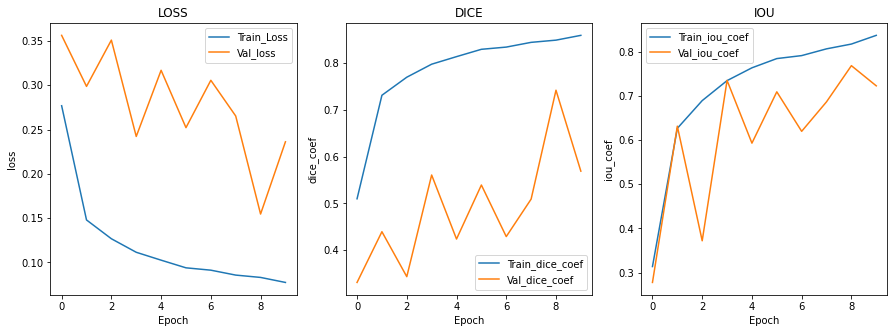

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

# Evaluation

In [ ]:
#save_model(model,'UNET_model')

'''
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}
model = load_model('./UNET_model', custom_objects=custom_objects)
'''

"\ncustom_objects = custom_objects={\n    'dice_coef': dice_coef,\n    'iou_coef': iou_coef,\n    'bce_dice_loss': bce_dice_loss\n}\nmodel = load_model('./UNET_model', custom_objects=custom_objects)\n"

In [ ]:
pred_batches = DataGenerator(X_valid.iloc[200:208,:], batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

8/8 [==============================] - 6s 50ms/step


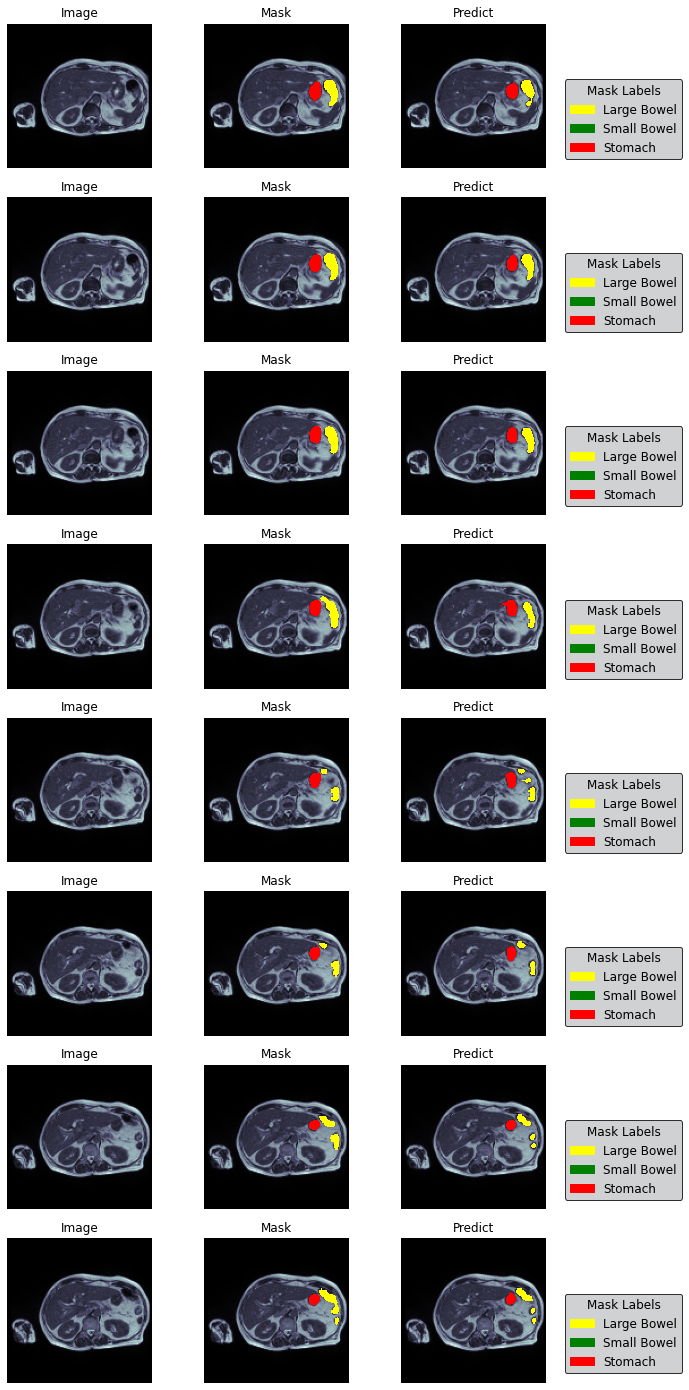

In [ ]:
Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


# Test set predictions

In [ ]:
#gcd(80,144)=16=BATCH_SIZE
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,128,128,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)

In [ ]:
submission.to_csv('submission.csv',index=False)
submission.sample(20)

id        class  \
111  case123_day20_slice_0038  large_bowel   
145  case123_day20_slice_0049  small_bowel   
293  case123_day20_slice_0098      stomach   
168  case123_day20_slice_0057  large_bowel   
194  case123_day20_slice_0065      stomach   
63   case123_day20_slice_0022  large_bowel   
101  case123_day20_slice_0034      stomach   
94   case123_day20_slice_0032  small_bowel   
222  case123_day20_slice_0075  large_bowel   
273  case123_day20_slice_0092  large_bowel   
164  case123_day20_slice_0055      stomach   
216  case123_day20_slice_0073  large_bowel   
103  case123_day20_slice_0035  small_bowel   
139  case123_day20_slice_0047  small_bowel   
155  case123_day20_slice_0052      stomach   
87   case123_day20_slice_0030  large_bowel   
70   case123_day20_slice_0024  small_bowel   
207  case123_day20_slice_0070  large_bowel   
214  case123_day20_slice_0072  small_bowel   
177  case123_day20_slice_0060  large_bowel   

                                            prediction  
111                                                     
145                                                     
293                                                     
168                                                     
194  28353 9 28619 9 28885 9 29151 11 29417 11 2968...  
63                                                      
101                                                     
94                                                      
222  23058 4 23324 4 23588 9 23854 9 24120 9 24386 ...  
273  15332 6 15598 6 15864 10 15878 11 16130 10 161...  
164                                                     
216                                                     
103                                                     
139                                                     
155                                                     
87                                                      
70                                                      
207                                                     
214                                                     
177